# init

In [1]:
import warnings
warnings.filterwarnings('ignore')


In [2]:
import os
os.environ['KMP_DUPLICATE_LIB_OK']='True' # for XGBoost

import pickle
import cloudpickle
import cv2

import pandas as pd
import numpy  as np
import matplotlib.pyplot as plt 
import japanize_matplotlib

from datetime                import datetime

from sklearn.ensemble        import RandomForestClassifier
from xgboost                 import XGBClassifier
from lightgbm                import LGBMClassifier
from catboost                import CatBoostClassifier
from sklearn.linear_model    import LogisticRegression

from sklearn                 import datasets
from sklearn.model_selection import train_test_split
from copy                    import copy
from umap                    import UMAP

np.random.seed(0)


/home/mucunwuxian/.local/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [3]:
import torch
import torch.nn as nn
import torch.optim as optimizers
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader, TensorDataset
import torchvision
import torchvision.transforms as transforms
from torch import optim
from torch.optim import Adam


In [4]:
# 
np.random.seed(0)
torch.manual_seed(0)

# 
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)


cuda


In [5]:
# import domestic lib
import ppap.tabular_utility      as ppap_tbl_utl
import ppap.image_utility        as ppap_img_utl
import ppap.image_classification as ppap_img_cls

import importlib
importlib.reload(ppap_tbl_utl)
importlib.reload(ppap_img_utl)
importlib.reload(ppap_img_cls)


<module 'ppap.image_classification' from '/home/mucunwuxian/20191125_PPAP/ppap/image_classification.py'>

(28, 28)
255
0
[0.07142857 0.17857143 0.28571429 0.39285714]
2
-8
5
-11


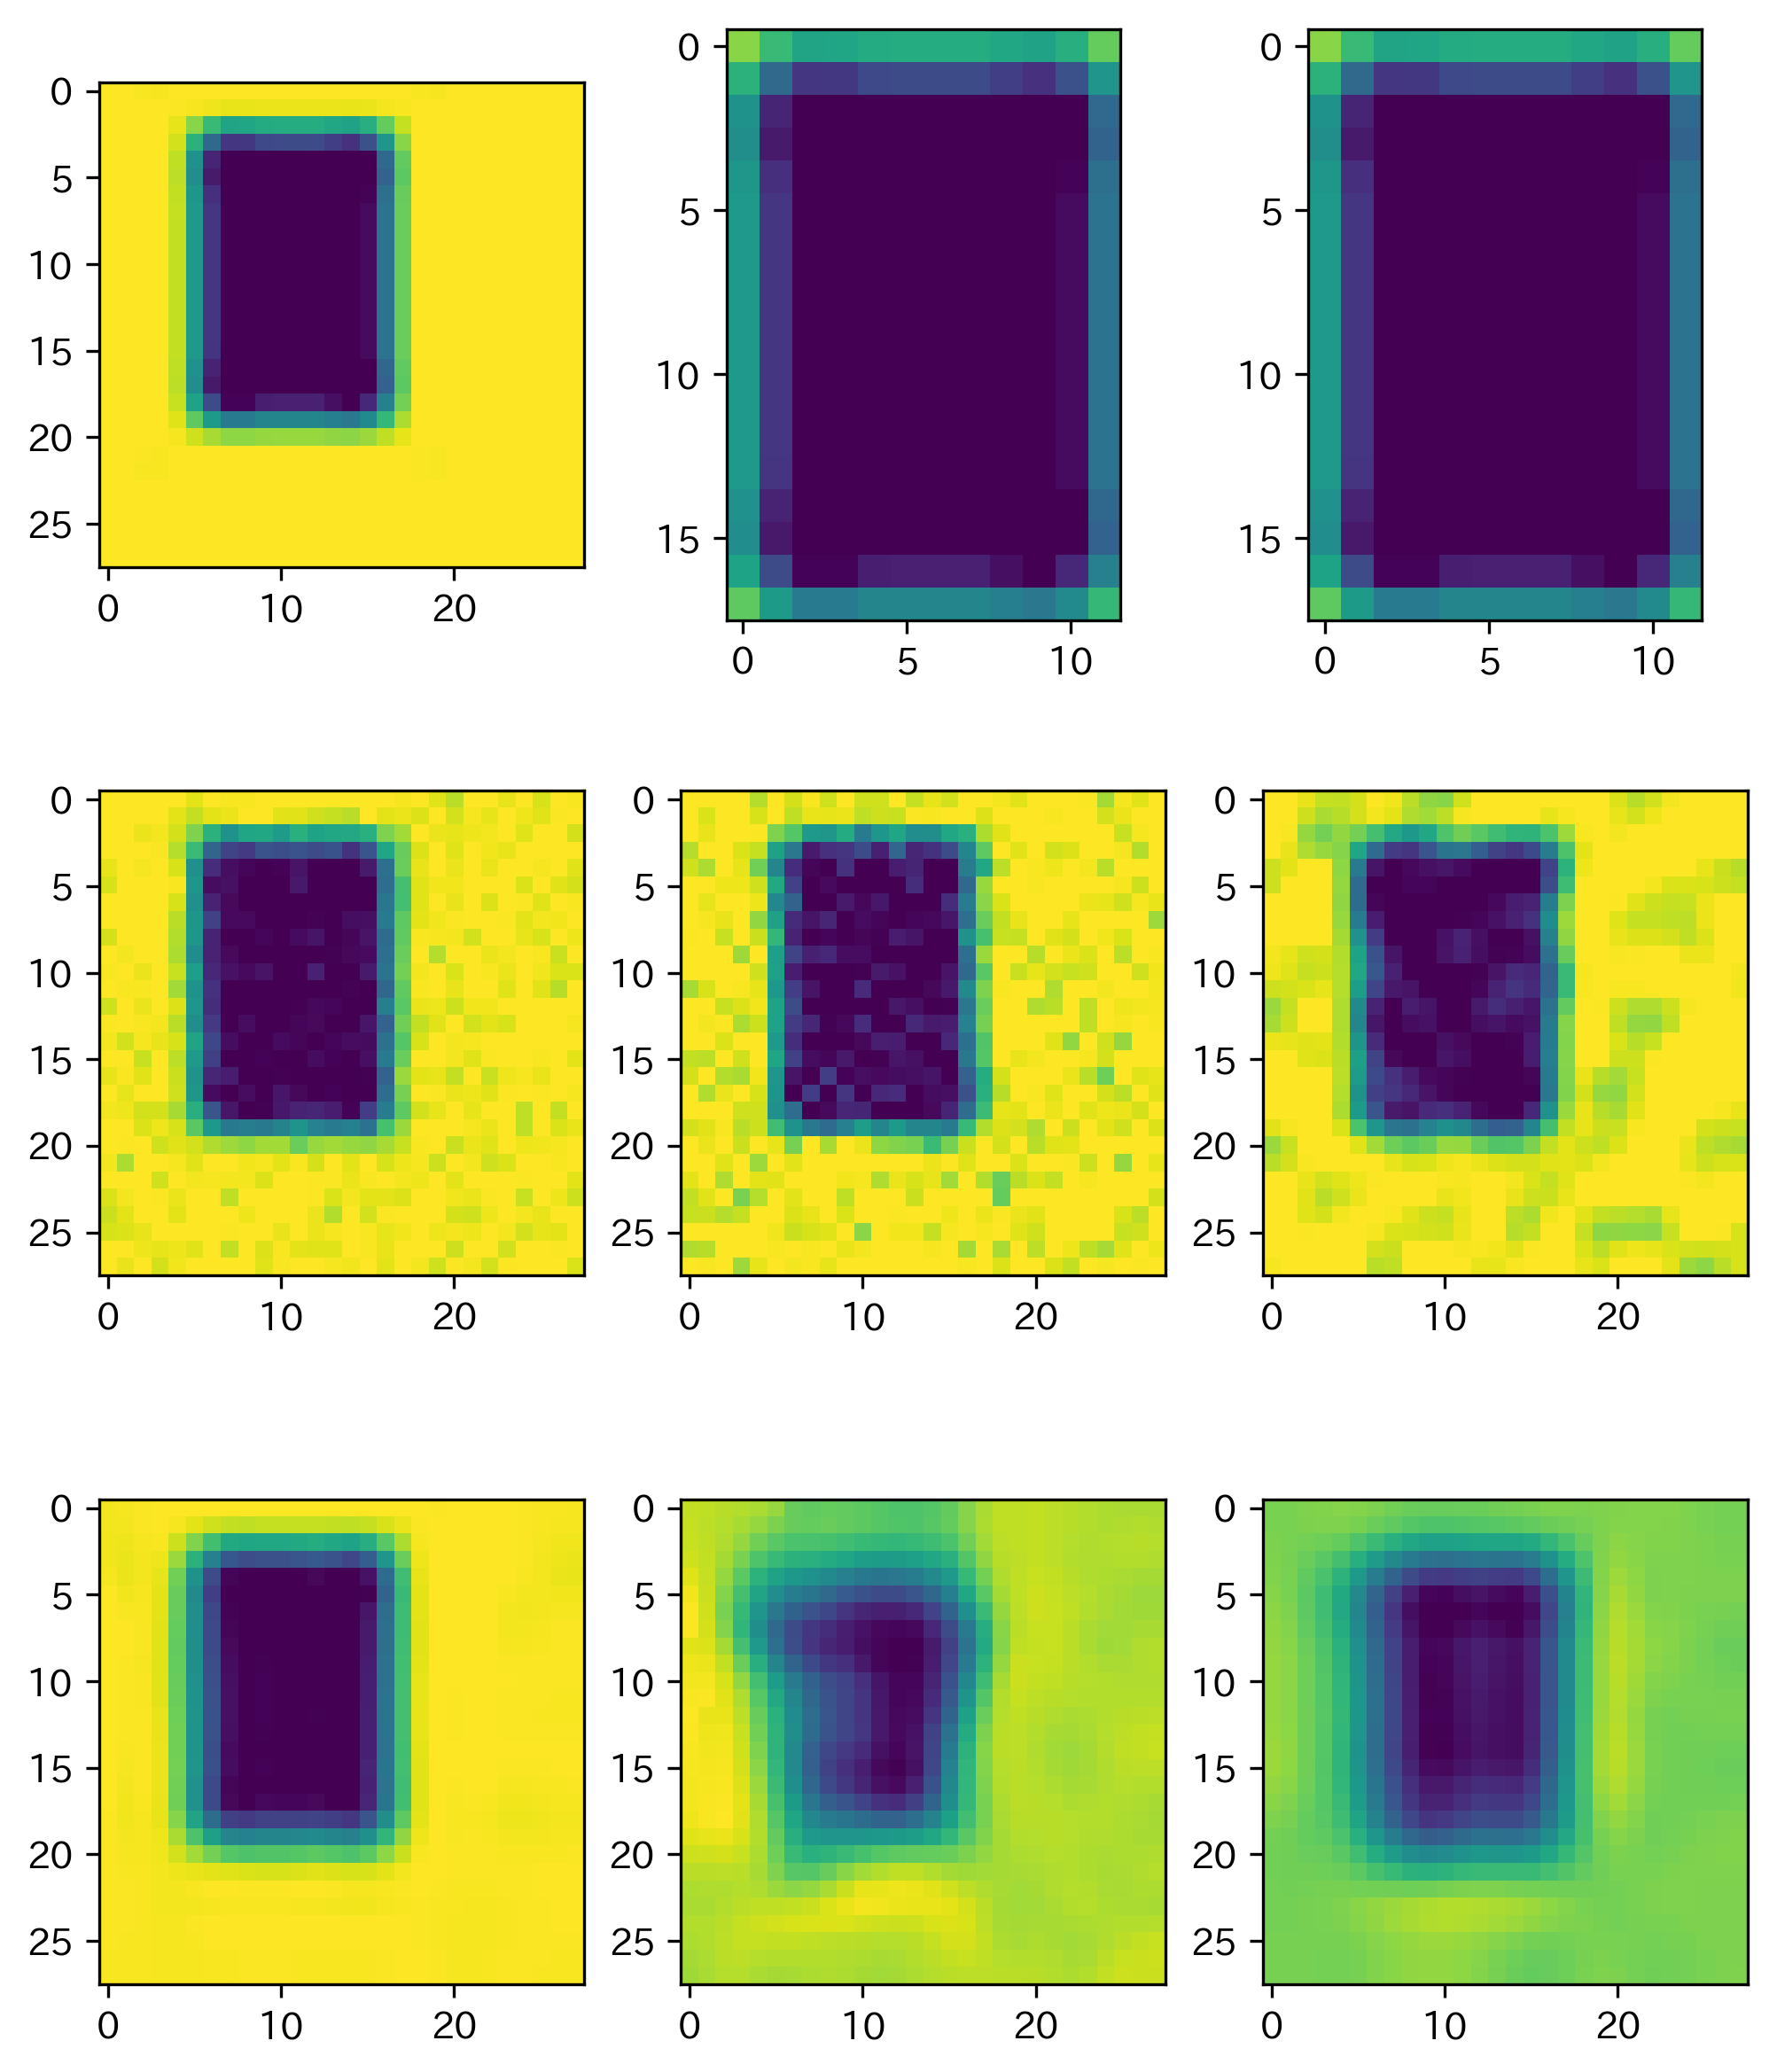

In [6]:
# test
tmp             = np.ones([10, 10], dtype=np.uint8) * 255
tmp[1:-3, 2:-4] = 0
tmp             = ppap_img_utl.imresize(tmp, height_pixel=28)
print(np.shape(tmp))
print(np.max(tmp))
print(np.min(tmp))

# 
plt.figure(figsize=(8,10),dpi=300)
plt.subplot(3, 3, 1)
plt.imshow(tmp, clim=[0, 255])

# 
(tmp_, adjust_ratio_tmp) = ppap_img_utl.imtrimming(tmp)

# 
print(adjust_ratio_tmp)

# 
plt.subplot(3, 3, 2)
plt.imshow(tmp_, clim=[0, 255])

vert_from = int(np.round(np.shape(tmp)[0]  * adjust_ratio_tmp[0]))
vert_to   = -int(np.round(np.shape(tmp)[0] * adjust_ratio_tmp[2]))
horz_from = int(np.round(np.shape(tmp)[1]  * adjust_ratio_tmp[1]))
horz_to   = -int(np.round(np.shape(tmp)[1] * adjust_ratio_tmp[3]))
print(vert_from)
print(vert_to)
print(horz_from)
print(horz_to)

# 
tmp___ = tmp[vert_from:vert_to, horz_from:horz_to]

# 
plt.subplot(3, 3, 3)
plt.imshow(tmp___, clim=[0, 255])

# 
tmp____   = ppap_img_utl.add_gaussian_noise(tmp, mean=0, sigma=10)
tmp_____  = ppap_img_utl.add_gaussian_noise(tmp, mean=0, sigma=20)
tmp______ = ppap_img_utl.add_gaussian_noise(tmp, mean=0, sigma=20, roughness=2)

# 
plt.subplot(3, 3, 4)
plt.imshow(tmp____, clim=[0, 255])

# 
plt.subplot(3, 3, 5)
plt.imshow(tmp_____, clim=[0, 255])

# 
plt.subplot(3, 3, 6)
plt.imshow(tmp______, clim=[0, 255])

# 
tmp_______   = ppap_img_utl.imaugment_for_char(img=tmp[np.newaxis, :, :], 
                                               window_size_vert=np.shape(tmp)[0])
tmp________  = ppap_img_utl.imaugment_for_char(img=tmp[np.newaxis, :, :], 
                                               window_size_vert=np.shape(tmp)[0])
tmp_________ = ppap_img_utl.imaugment_for_char(img=tmp[np.newaxis, :, :], 
                                               window_size_vert=np.shape(tmp)[0])

# 
plt.subplot(3, 3, 7)
plt.imshow(tmp_______[0], clim=[0, 255])

# 
plt.subplot(3, 3, 8)
plt.imshow(tmp________[0], clim=[0, 255])

# 
plt.subplot(3, 3, 9)
plt.imshow(tmp_________[0], clim=[0, 255])

plt.show()


In [7]:
# refer from [https://qiita.com/daenqiita/items/be92e332fb029bacd795]

import time

def tic():
    #require to import time
    global start_time_tictoc
    start_time_tictoc = time.time()


def toc(tag="elapsed time"):
    if "start_time_tictoc" in globals():
        print("{}: {:.5f} sec".format(tag, time.time() - start_time_tictoc), end='')
    else:
        print("tic has not been called")


# Pre-Process

In [8]:
# 
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', data_home='./data/mnist')

# prepare X and y
X = mnist.data
X = X.reshape(len(X), 28, 28)
y = mnist.target.astype(np.int)

# print size of X and y
print('np.shape(X) = (%d, %d, %d)' % np.shape(X))
print('np.max(X)   = %.2f'         % np.max(X))
print('np.shape(y) = (%d)'         % np.shape(y))
print('np.max(y)   = %.2f'         % np.max(y))


np.shape(X) = (70000, 28, 28)
np.max(X)   = 255.00
np.shape(y) = (70000)
np.max(y)   = 9.00


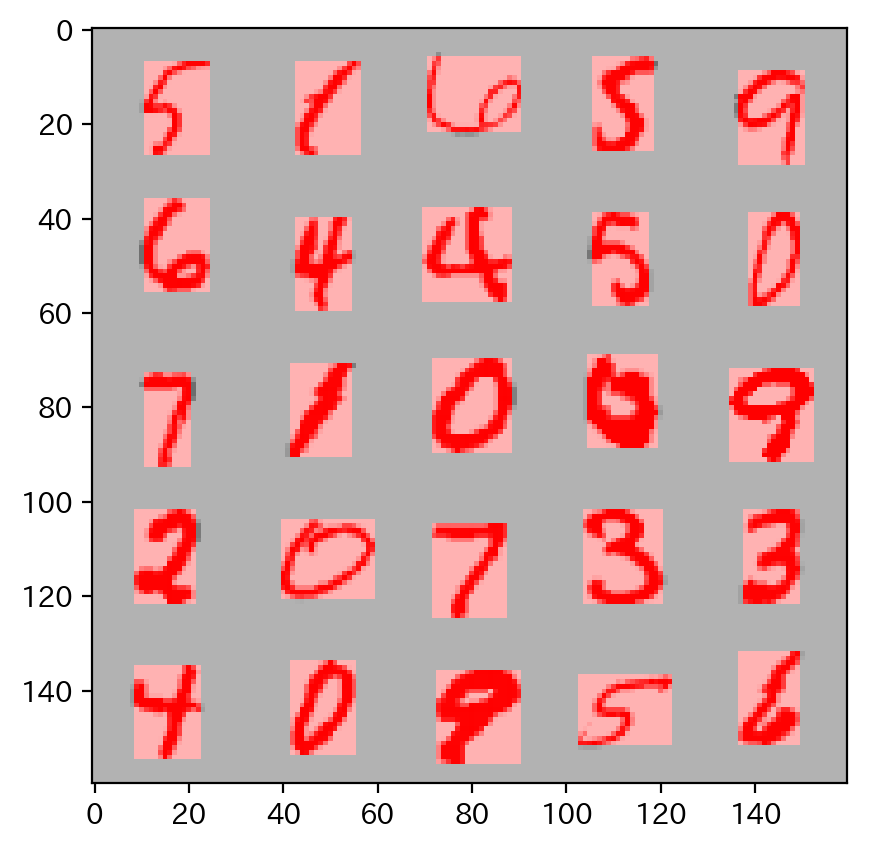

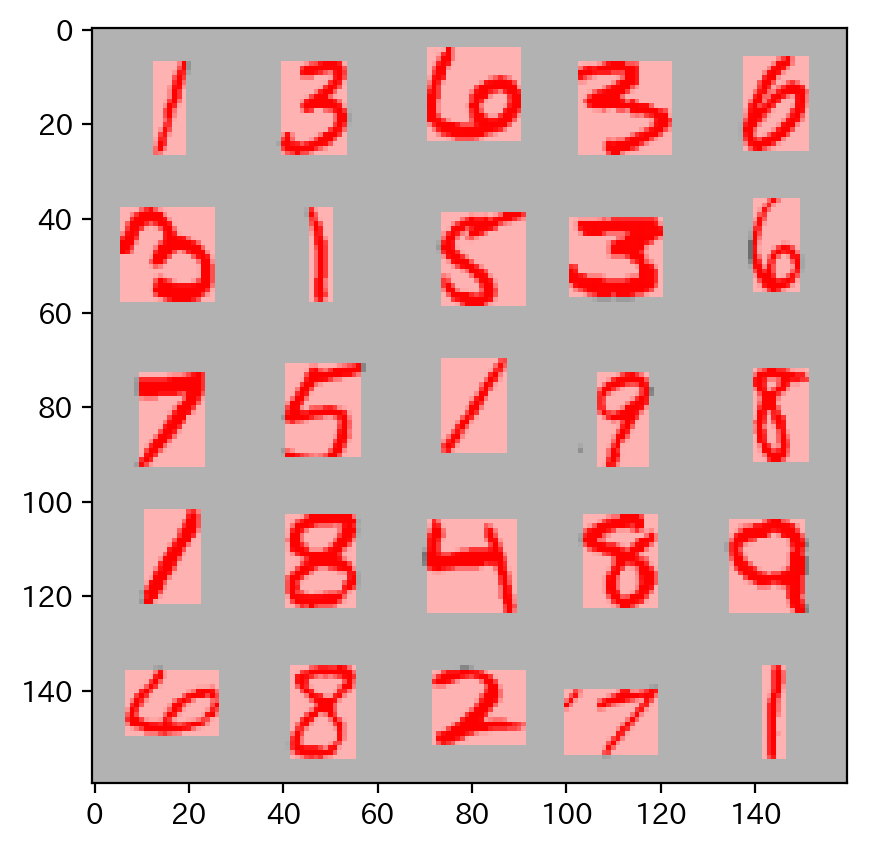

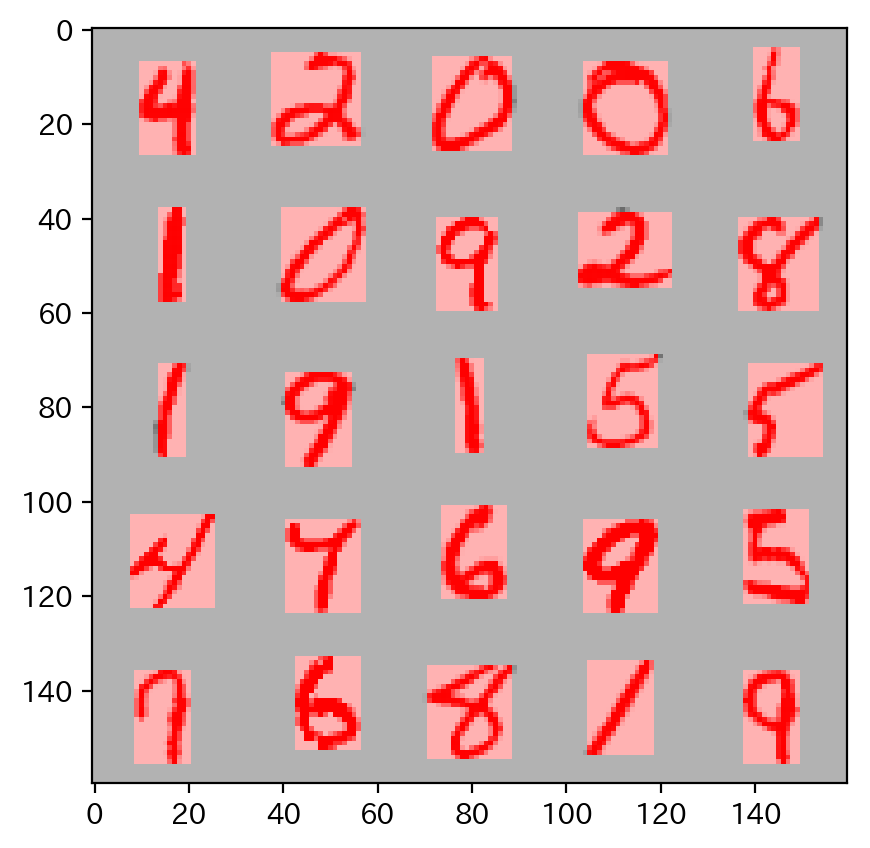

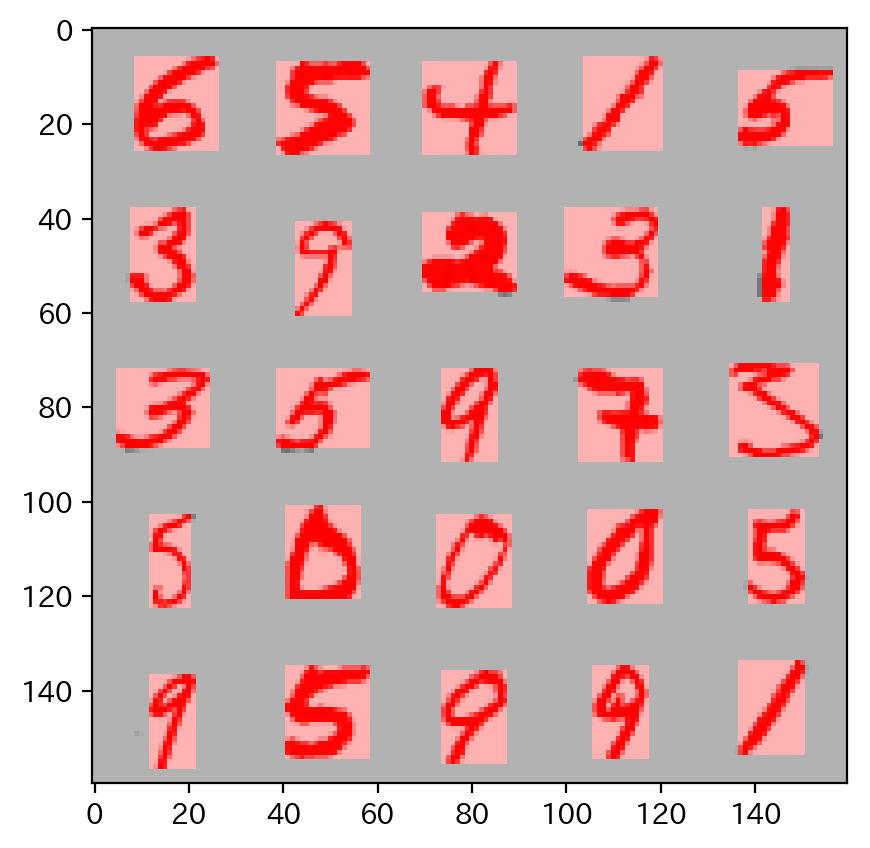

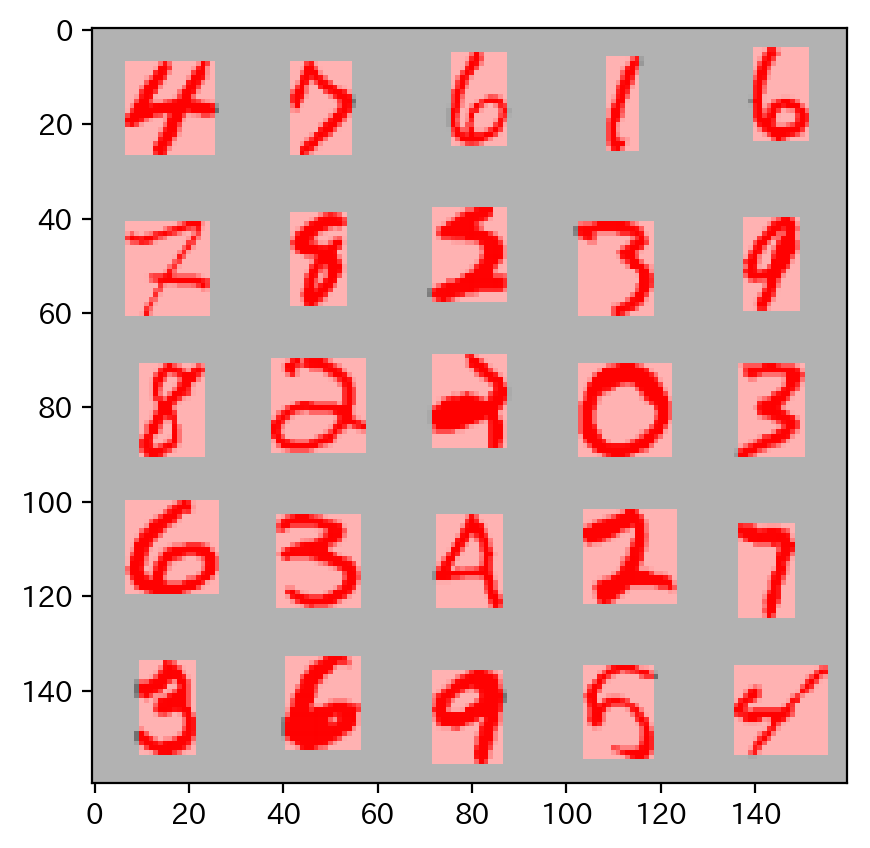

In [9]:
# make detection data
data_make_num        = 100
img_for_segmentation = []
ann_for_segmentation = []

# 
for img_make_i in range(data_make_num):
    
    # 
    char_vert_num = 5
    char_horz_num = 5
    img_tmp       = np.zeros([(32 * char_vert_num), (32 * char_horz_num)], dtype=np.float)
    ann_tmp       = np.zeros([(32 * char_vert_num), (32 * char_horz_num)], dtype=np.float)

    # 
    X_num = len(X)
    X_idx = np.random.permutation(np.arange(X_num))[:char_vert_num * char_horz_num]
    X_i   = 0

    # 
    for char_vert_i in range(char_vert_num):
        # 
        for char_horz_i in range(char_horz_num):
            # 
            coord_top     = int((32 * char_vert_i) + 2)
            coord_bottom  = int(coord_top + 28)
            coord_left    = int((32 * char_horz_i) + 2)
            coord_right   = int(coord_left + 28)
            # 
            X_tmp = X[X_idx[X_i]]
            X_i  += 1
            # 
            img_tmp[coord_top:coord_bottom, 
                    coord_left:coord_right] = X_tmp
            
            # 
            (_, adjust_ratio_tmp) = ppap_img_utl.imtrimming(255 - X_tmp)
            #
            adjust_top    = int(np.round(np.shape(X_tmp)[0]  * adjust_ratio_tmp[0]))
            adjust_bottom = -int(np.round(np.shape(X_tmp)[0] * adjust_ratio_tmp[2]))
            adjust_left   = int(np.round(np.shape(X_tmp)[1]  * adjust_ratio_tmp[1]))
            adjust_right  = -int(np.round(np.shape(X_tmp)[1] * adjust_ratio_tmp[3]))
            # 
            coord_top    += adjust_top 
            coord_bottom += adjust_bottom 
            coord_left   += adjust_left
            coord_right  += adjust_right
            # 
            ann_tmp[coord_top:coord_bottom, 
                    coord_left:coord_right] = 1

    # 
    img_for_segmentation.append(img_tmp)
    ann_for_segmentation.append(ann_tmp)
    
    # 
    if (img_make_i < 5):
        # 
        show_img  = np.concatenate([(255 - img_tmp[:, :, np.newaxis]), 
                                    (255 - img_tmp[:, :, np.newaxis]), 
                                    (255 - img_tmp[:, :, np.newaxis])], axis=2) * 0.7
        show_img += np.concatenate([ann_tmp[:, :, np.newaxis], 
                                    np.zeros([(32 * char_vert_num), (32 * char_horz_num), 1]), 
                                    np.zeros([(32 * char_vert_num), (32 * char_horz_num), 1])], axis=2) * 255
        show_img  = np.clip(show_img, 0, 255).astype(np.uint8)
        # 
        plt.figure(figsize=(5,5),dpi=200)
        plt.imshow(show_img, clim=[0, 255])
        plt.show()


In [10]:
# redefine X and y
X_train = np.array(img_for_segmentation)
X_train = X_train / 255
y_train = np.array(ann_for_segmentation)

# 
print('np.shape(X_train) = (%d, %d, %d)' % np.shape(X_train))
print('np.max(X_train)   = %.2f'         % np.max(X_train))
print('np.shape(y_train) = (%d, %d, %d)' % np.shape(y_train))
print('np.max(y_train)   = %.2f'         % np.max(y_train))


np.shape(X_train) = (100, 160, 160)
np.max(X_train)   = 1.00
np.shape(y_train) = (100, 160, 160)
np.max(y_train)   = 1.00


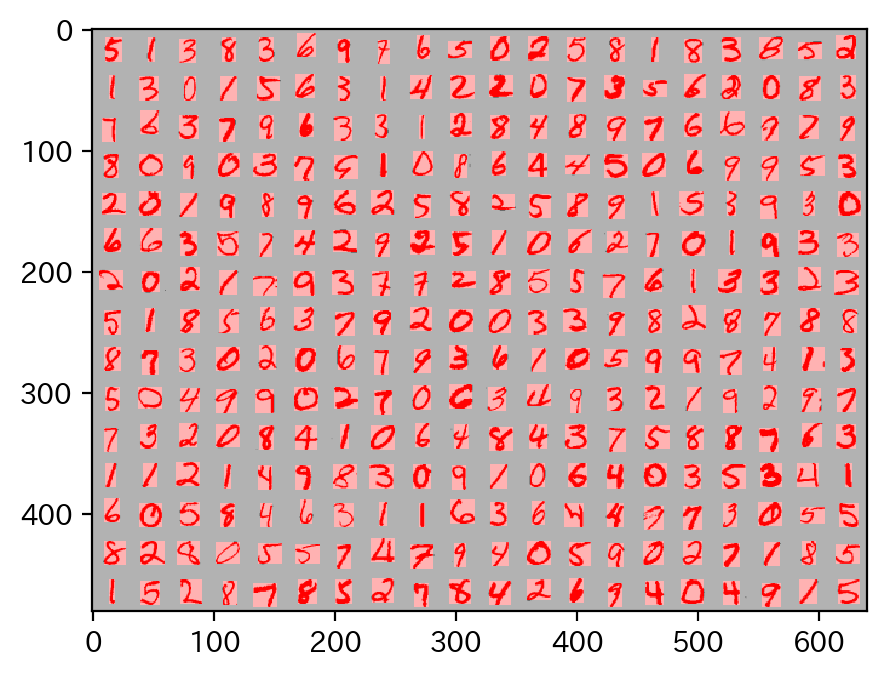

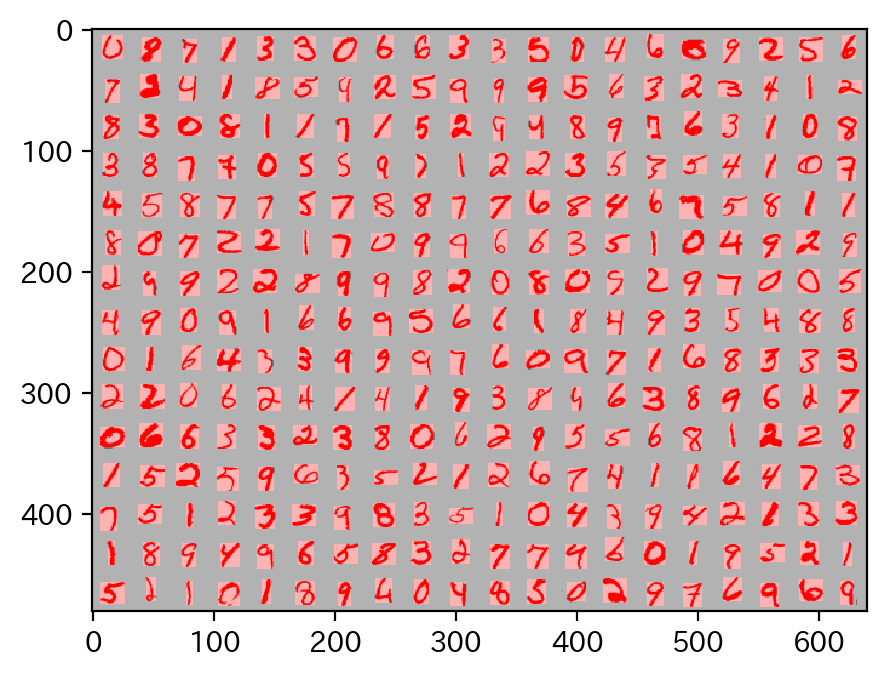

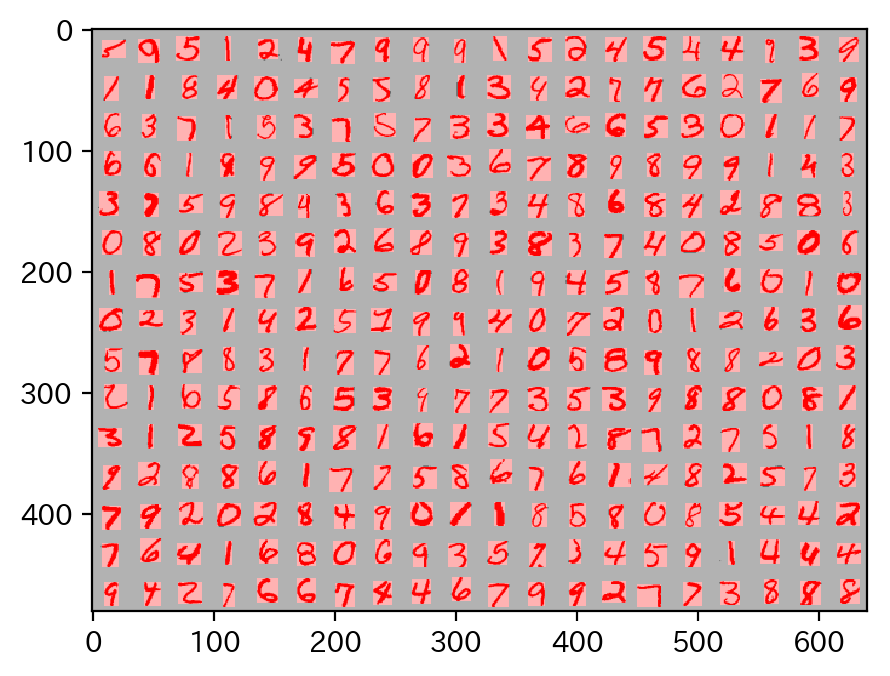

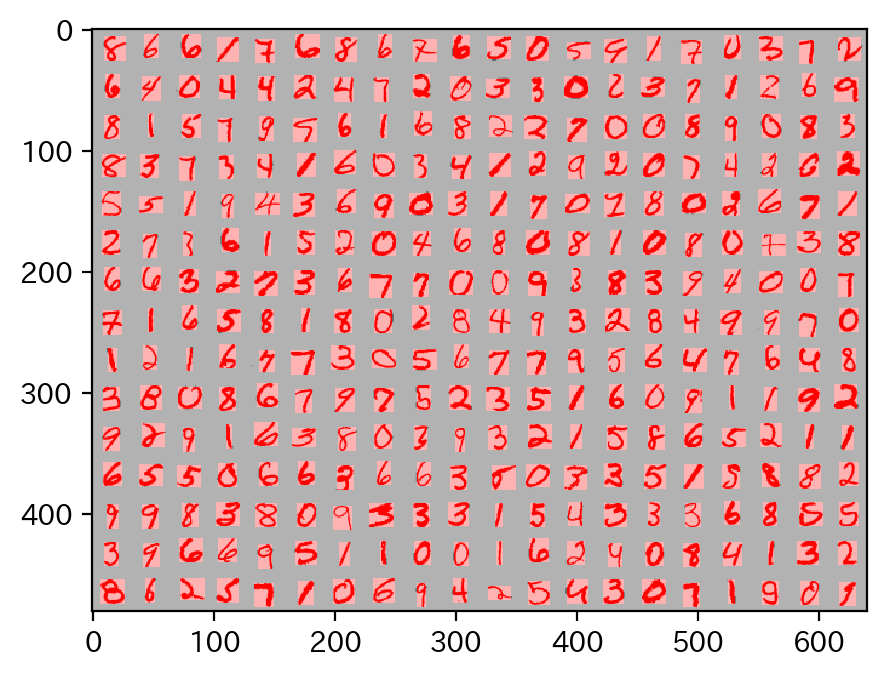

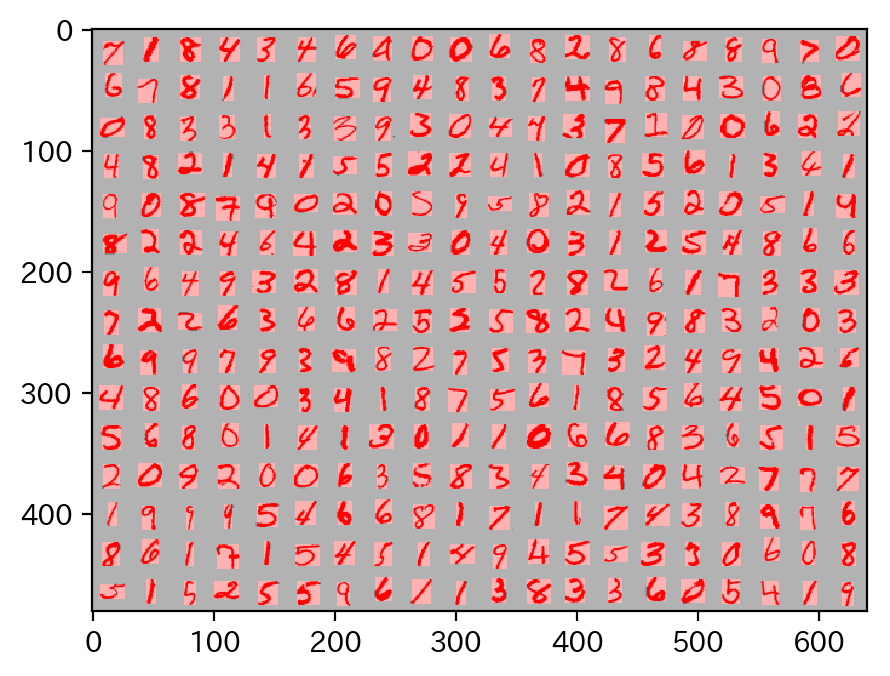

In [11]:
# make detection data
data_make_num        = 10
img_for_segmentation = []
ann_for_segmentation = []

# 
for img_make_i in range(data_make_num):
    
    # 
    char_vert_num = 15
    char_horz_num = 20
    img_tmp       = np.zeros([(32 * char_vert_num), (32 * char_horz_num)], dtype=np.float)
    ann_tmp       = np.zeros([(32 * char_vert_num), (32 * char_horz_num)], dtype=np.float)

    # 
    X_num = len(X)
    X_idx = np.random.permutation(np.arange(X_num))[:char_vert_num * char_horz_num]
    X_i   = 0

    # 
    for char_vert_i in range(char_vert_num):
        # 
        for char_horz_i in range(char_horz_num):
            # 
            coord_top     = int((32 * char_vert_i) + 2)
            coord_bottom  = int(coord_top + 28)
            coord_left    = int((32 * char_horz_i) + 2)
            coord_right   = int(coord_left + 28)
            # 
            X_tmp = X[X_idx[X_i]]
            X_i  += 1
            # 
            img_tmp[coord_top:coord_bottom, 
                    coord_left:coord_right] = X_tmp
            
            # 
            (_, adjust_ratio_tmp) = ppap_img_utl.imtrimming(255 - X_tmp)
            #
            adjust_top    = int(np.round(np.shape(X_tmp)[0]  * adjust_ratio_tmp[0]))
            adjust_bottom = -int(np.round(np.shape(X_tmp)[0] * adjust_ratio_tmp[2]))
            adjust_left   = int(np.round(np.shape(X_tmp)[1]  * adjust_ratio_tmp[1]))
            adjust_right  = -int(np.round(np.shape(X_tmp)[1] * adjust_ratio_tmp[3]))
            # 
            coord_top    += adjust_top 
            coord_bottom += adjust_bottom 
            coord_left   += adjust_left
            coord_right  += adjust_right
            # 
            ann_tmp[coord_top:coord_bottom, 
                    coord_left:coord_right] = 1

    # 
    img_for_segmentation.append(img_tmp)
    ann_for_segmentation.append(ann_tmp)
    
    # 
    if (img_make_i < 5):
        # 
        show_img  = np.concatenate([(255 - img_tmp[:, :, np.newaxis]), 
                                    (255 - img_tmp[:, :, np.newaxis]), 
                                    (255 - img_tmp[:, :, np.newaxis])], axis=2) * 0.7
        show_img += np.concatenate([ann_tmp[:, :, np.newaxis], 
                                    np.zeros([(32 * char_vert_num), (32 * char_horz_num), 1]), 
                                    np.zeros([(32 * char_vert_num), (32 * char_horz_num), 1])], axis=2) * 255
        show_img  = np.clip(show_img, 0, 255).astype(np.uint8)
        # 
        plt.figure(figsize=(5,5),dpi=200)
        plt.imshow(show_img, clim=[0, 255])
        plt.show()


In [12]:
# redefine X and y
X_test = np.array(img_for_segmentation)
X_test = X_test / 255
y_test = np.array(ann_for_segmentation)

# 
print('np.shape(X_test) = (%d, %d, %d)' % np.shape(X_test))
print('np.max(X_test)   = %.2f'         % np.max(X_test))
print('np.shape(y_test) = (%d, %d, %d)' % np.shape(y_test))
print('np.max(y_test)   = %.2f'         % np.max(y_test))


np.shape(X_test) = (10, 480, 640)
np.max(X_test)   = 1.00
np.shape(y_test) = (10, 480, 640)
np.max(y_test)   = 1.00


# Prediction 

In [13]:
# 
class double_conv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(double_conv, self).__init__()
        self.conv = nn.Sequential(
            nn.Conv2d(in_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True),
            nn.Conv2d(out_ch, out_ch, 3, padding=1),
            nn.BatchNorm2d(out_ch),
            nn.ReLU(inplace=True)
        )

    def forward(self, x):
        x = self.conv(x)
        return x

# 
class inconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(inconv, self).__init__()
        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x):
        x = self.conv(x)
        return x

#
class down(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(down, self).__init__()
        self.mpconv = nn.Sequential(
            nn.MaxPool2d(2),
            double_conv(in_ch, out_ch)
        )

    def forward(self, x):
        x = self.mpconv(x)
        return x

#
class up(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(up, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        # same channel, h*2, w*2
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            #pix2pix
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        return x

# 
class preup(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(preup, self).__init__()

        #  would be a nice idea if the upsampling could be learned too,
        #  but my machine do not have enough memory to handle all those weights
        # same channel, h*2, w*2
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            #pix2pix
            self.up = nn.ConvTranspose2d(in_ch//2, in_ch//2, 2, stride=2)

        self.conv1 = double_conv(in_ch, out_ch)
        self.conv2 = double_conv(in_ch, out_ch)

    def forward(self, x1, x2):
        x1 = self.up(x1)

        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        x1 = F.pad(x1, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        # for padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd

        x1 = self.conv1(x1)

        x = torch.cat([x2, x1], dim=1)
        x = self.conv2(x)
        return x

# x1: 128, x12: 128, x2:256
# default up function:
# x2 up -> x2:128, cat(x1, x2)->256, conv -> out:64
#
# resup idea 1:
# x2.up and conv -> x2:128, cat(x1, x12, x2) -> 128*4, conv-> out:64
#
# resup idea 2:
# cat(x2, x12, x2) -> 512, upconv: 256, upconv-> 128, upconv->out:64
#                          (conv: 512 -> 64)
#
# resup idea 3:
# x2.up -> x2:128
# cat(x1, x12) -> 256 -> upconv -> tmp:128
# cat(tmp, x2):256, conv-> out:64

#idea 1
class resup(nn.Module):
    def __init__(self, in_ch, out_ch, bilinear=True):
        super(resup, self).__init__()

        if bilinear:
            self.up1 = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
        else:
            self.up1 = nn.ConvTranspose2d(in_ch//4, in_ch//4, kernel_size=1, stride=2)

        self.conv1 = double_conv(in_ch//4, in_ch//2)
        self.conv2 = double_conv(in_ch, out_ch)

    def forward(self, x1, x12, x2):
        x2 = self.up1(x2)
        x2 = self.conv1(x2)

        diffY = x1.size()[2] - x2.size()[2]
        diffX = x1.size()[3] - x2.size()[3]

        x2 = F.pad(x2, (diffX // 2, diffX - diffX//2,
                        diffY // 2, diffY - diffY//2))

        x = torch.cat([x1, x12, x2], dim=1)
        x = self.conv2(x)

        return x

# 
class outconv(nn.Module):
    def __init__(self, in_ch, out_ch):
        super(outconv, self).__init__()
        self.conv = nn.Conv2d(in_ch, out_ch, 1)

    def forward(self, x):
        x = self.conv(x)
        return x


In [14]:
# 
class UNet(nn.Module):
    def __init__(self, n_channels, n_classes):
        super(UNet, self).__init__()
        self.inc = inconv(n_channels, 64)
        self.down1 = down(64, 128)
        self.down2 = down(128, 256)
        self.down3 = down(256, 512)
        self.down4 = down(512, 512)
        self.up1 = up(1024, 256)
        self.up2 = up(512, 128)
        self.up3 = up(256, 64)
        self.up4 = up(128, 64)
        self.outc = outconv(64, n_classes)

    def forward(self, x):
        x1 = self.inc(x)
        x2 = self.down1(x1)
        x3 = self.down2(x2)
        x4 = self.down3(x3)
        x5 = self.down4(x4)
        x = self.up1(x5, x4)
        x = self.up2(x, x3)
        x = self.up3(x, x2)
        x = self.up4(x, x1)
        x = self.outc(x)
        return F.sigmoid(x)


In [15]:
# 
from torch.optim.optimizer import Optimizer
import math

# 
class RAdam(Optimizer):

    def __init__(self, params, lr=1e-3, betas=(0.9, 0.999), eps=1e-8, weight_decay=0, degenerated_to_sgd=True):
        if not 0.0 <= lr:
            raise ValueError("Invalid learning rate: {}".format(lr))
        if not 0.0 <= eps:
            raise ValueError("Invalid epsilon value: {}".format(eps))
        if not 0.0 <= betas[0] < 1.0:
            raise ValueError("Invalid beta parameter at index 0: {}".format(betas[0]))
        if not 0.0 <= betas[1] < 1.0:
            raise ValueError("Invalid beta parameter at index 1: {}".format(betas[1]))
        
        self.degenerated_to_sgd = degenerated_to_sgd
        if isinstance(params, (list, tuple)) and len(params) > 0 and isinstance(params[0], dict):
            for param in params:
                if 'betas' in param and (param['betas'][0] != betas[0] or param['betas'][1] != betas[1]):
                    param['buffer'] = [[None, None, None] for _ in range(10)]
        defaults = dict(lr=lr, betas=betas, eps=eps, weight_decay=weight_decay, buffer=[[None, None, None] for _ in range(10)])
        super(RAdam, self).__init__(params, defaults)

    def __setstate__(self, state):
        super(RAdam, self).__setstate__(state)

    def step(self, closure=None):

        loss = None
        if closure is not None:
            loss = closure()

        for group in self.param_groups:

            for p in group['params']:
                if p.grad is None:
                    continue
                grad = p.grad.data.float()
                if grad.is_sparse:
                    raise RuntimeError('RAdam does not support sparse gradients')

                p_data_fp32 = p.data.float()

                state = self.state[p]

                if len(state) == 0:
                    state['step'] = 0
                    state['exp_avg'] = torch.zeros_like(p_data_fp32)
                    state['exp_avg_sq'] = torch.zeros_like(p_data_fp32)
                else:
                    state['exp_avg'] = state['exp_avg'].type_as(p_data_fp32)
                    state['exp_avg_sq'] = state['exp_avg_sq'].type_as(p_data_fp32)

                exp_avg, exp_avg_sq = state['exp_avg'], state['exp_avg_sq']
                beta1, beta2 = group['betas']

                exp_avg_sq.mul_(beta2).addcmul_(1 - beta2, grad, grad)
                exp_avg.mul_(beta1).add_(1 - beta1, grad)

                state['step'] += 1
                buffered = group['buffer'][int(state['step'] % 10)]
                if state['step'] == buffered[0]:
                    N_sma, step_size = buffered[1], buffered[2]
                else:
                    buffered[0] = state['step']
                    beta2_t = beta2 ** state['step']
                    N_sma_max = 2 / (1 - beta2) - 1
                    N_sma = N_sma_max - 2 * state['step'] * beta2_t / (1 - beta2_t)
                    buffered[1] = N_sma

                    # more conservative since it's an approximated value
                    if N_sma >= 5:
                        step_size = math.sqrt((1 - beta2_t) * (N_sma - 4) / (N_sma_max - 4) * (N_sma - 2) / N_sma * N_sma_max / (N_sma_max - 2)) / (1 - beta1 ** state['step'])
                    elif self.degenerated_to_sgd:
                        step_size = 1.0 / (1 - beta1 ** state['step'])
                    else:
                        step_size = -1
                    buffered[2] = step_size

                # more conservative since it's an approximated value
                if N_sma >= 5:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    denom = exp_avg_sq.sqrt().add_(group['eps'])
                    p_data_fp32.addcdiv_(-step_size * group['lr'], exp_avg, denom)
                    p.data.copy_(p_data_fp32)
                elif step_size > 0:
                    if group['weight_decay'] != 0:
                        p_data_fp32.add_(-group['weight_decay'] * group['lr'], p_data_fp32)
                    p_data_fp32.add_(-step_size * group['lr'], exp_avg)
                    p.data.copy_(p_data_fp32)

        return loss


In [16]:
# training setting
epoch_num        = 20
pick_per_epoch   = 1.0
train_batch_size = 1
lr               = 0.003
momentum         = 0.9
weight_decay     = 0.1
gpu_parallel     = True


In [17]:
# 
model = UNet(n_channels=1, 
             n_classes=1).to(device)

# make parallel
if (gpu_parallel == True):
    model = torch.nn.DataParallel(model, device_ids=[0, 1]) # make parallel


In [18]:
# 
loss_func = nn.BCELoss()
# optimizer = optim.SGD(model.parameters(), 
#                       lr=lr, 
#                       momentum=momentum, 
#                       weight_decay=weight_decay)
optimizer = RAdam(model.parameters(), 
                  lr=lr, 
                  betas=(momentum, 0.999), 
                  weight_decay=weight_decay)


epoch:1
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.27, test = 0.27  [elapsed time: 8.02898 sec]



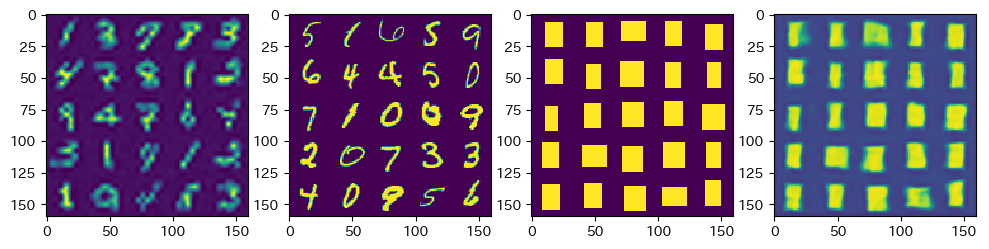

epoch:2
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.17, test = 0.17  [elapsed time: 5.96571 sec]



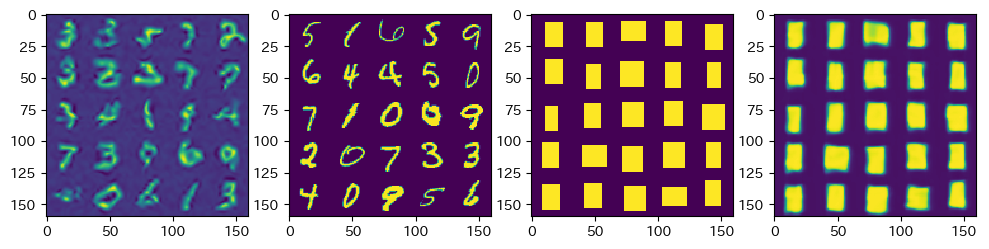

epoch:3
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.15, test = 0.14  [elapsed time: 5.47279 sec]



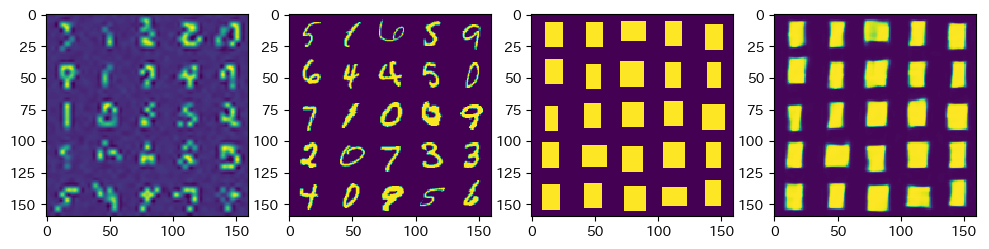

epoch:4
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.14, test = 0.13  [elapsed time: 5.57834 sec]



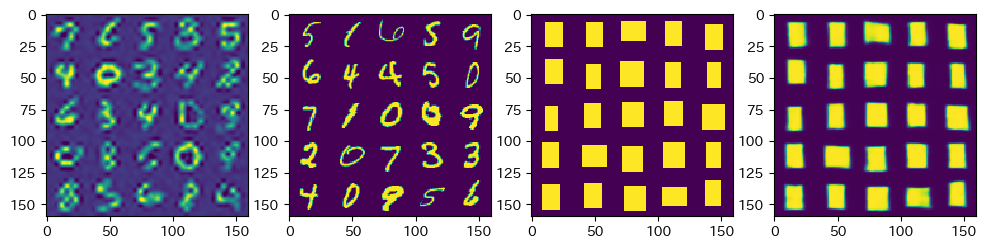

epoch:5
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.14, test = 0.13  [elapsed time: 5.35249 sec]



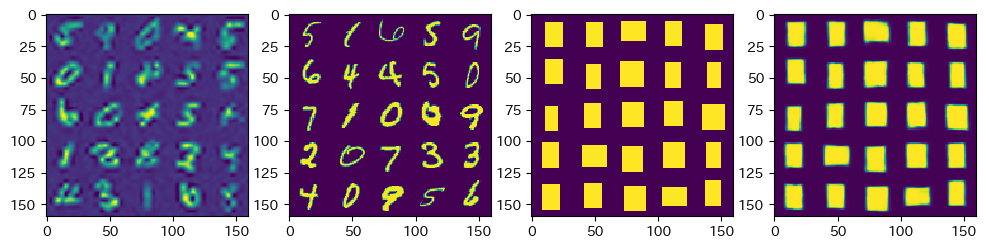

epoch:6
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.14, test = 0.13  [elapsed time: 6.10307 sec]



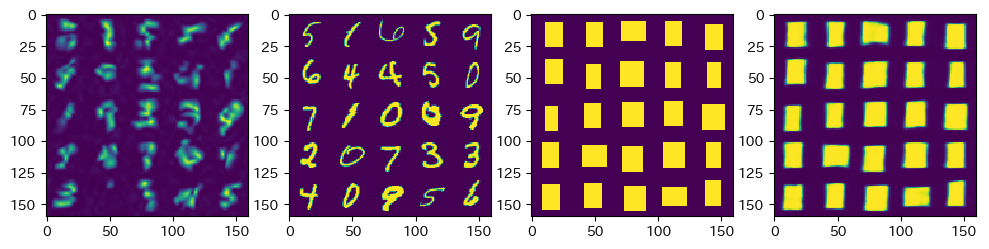

epoch:7
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.14, test = 0.13  [elapsed time: 6.00162 sec]



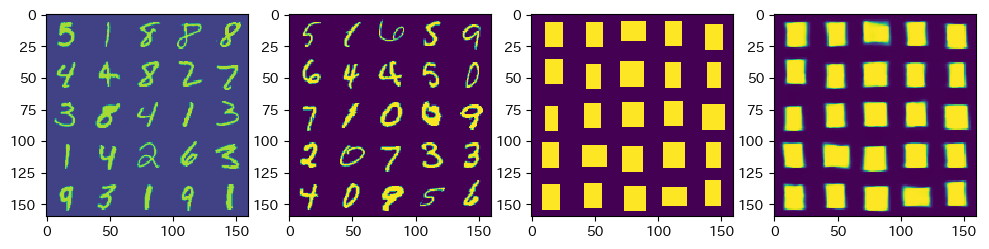

epoch:8
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.15, test = 0.14  [elapsed time: 6.27807 sec]



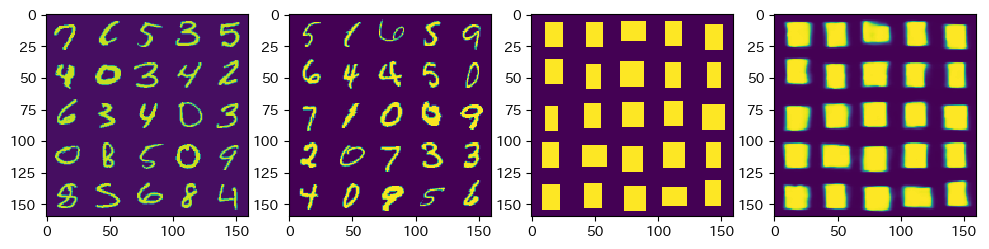

epoch:9
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.13, test = 0.12  [elapsed time: 6.01943 sec]



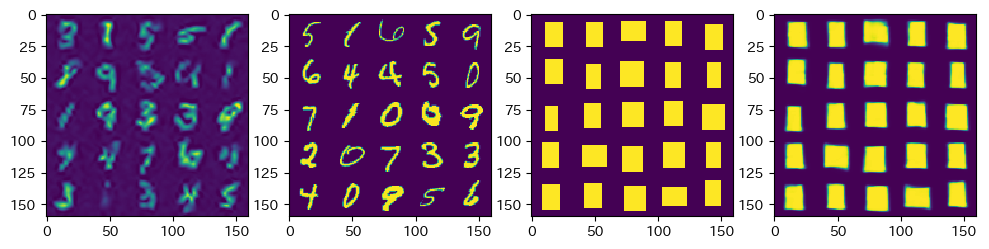

epoch:10
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.17, test = 0.16  [elapsed time: 6.04803 sec]



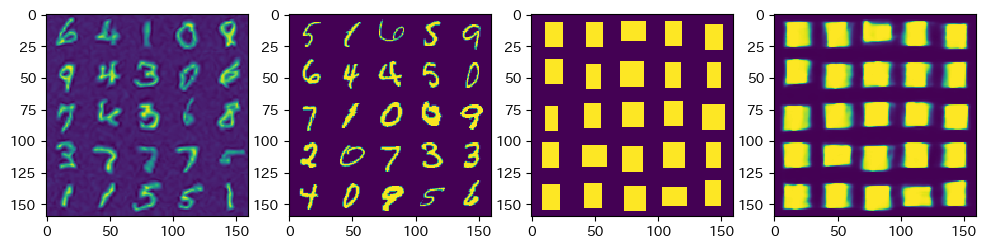

epoch:11
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.13, test = 0.12  [elapsed time: 6.22055 sec]



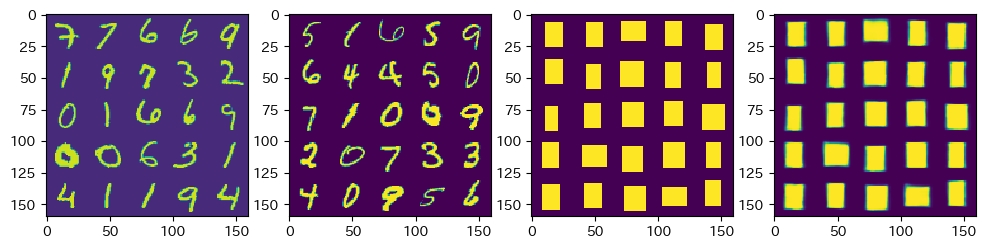

epoch:12
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.20, test = 0.20  [elapsed time: 6.41549 sec]



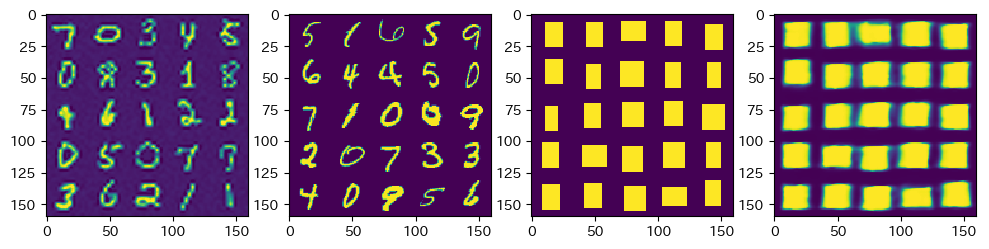

epoch:13
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.13, test = 0.12  [elapsed time: 5.89325 sec]



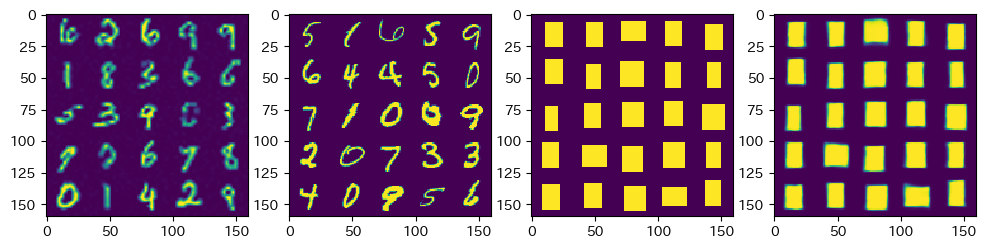

epoch:14
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.18, test = 0.17  [elapsed time: 8.32273 sec]



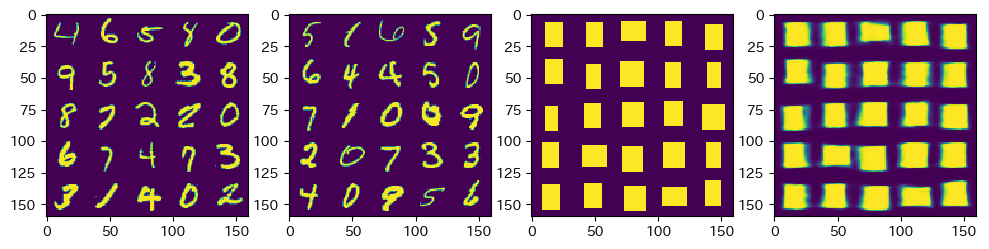

epoch:15
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.14, test = 0.13  [elapsed time: 6.45813 sec]



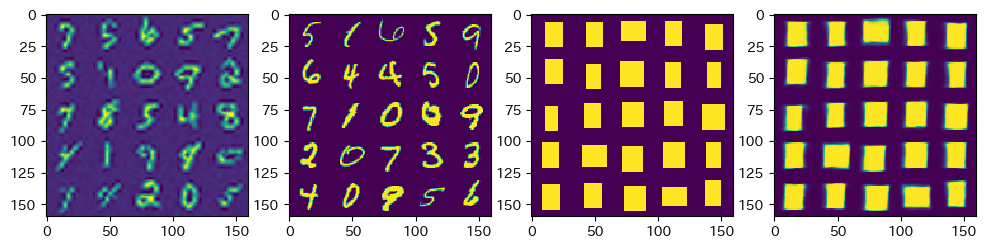

epoch:16
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.14, test = 0.14  [elapsed time: 6.05946 sec]



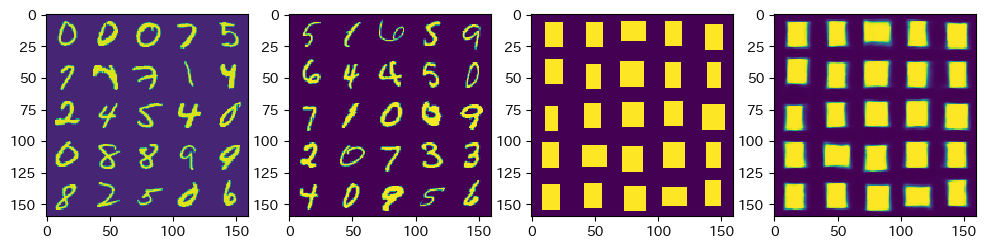

epoch:17
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.13, test = 0.13  [elapsed time: 6.15427 sec]



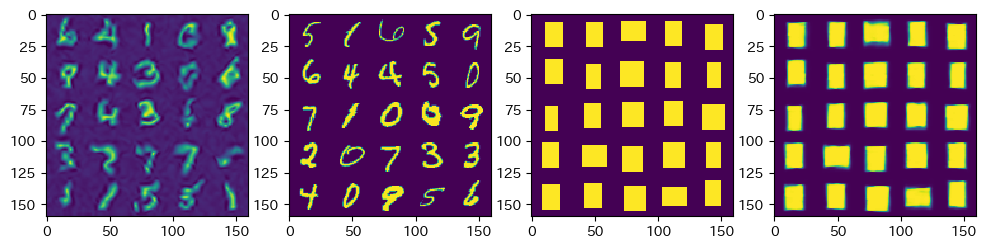

epoch:18
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.16, test = 0.15  [elapsed time: 6.19209 sec]



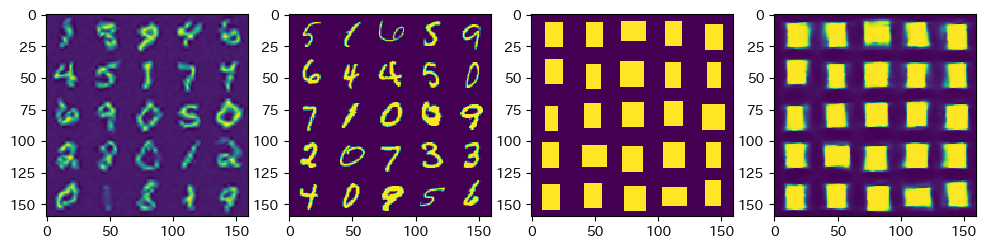

epoch:19
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.21, test = 0.21  [elapsed time: 5.99371 sec]



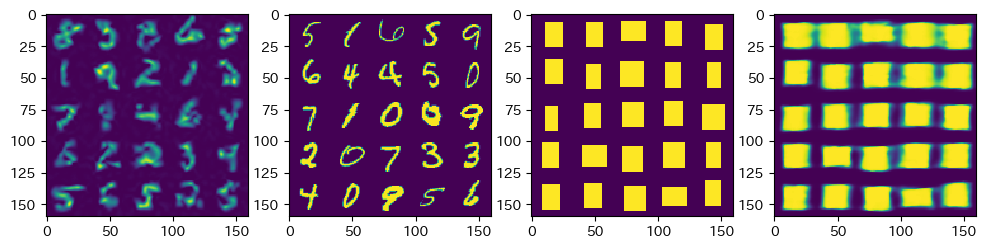

epoch:20
--------------------------------------------------
START                                          END
----+----1----+----2----+----3----+----4----+----5
**************************************************
Accuracy on train = 0.16, test = 0.15  [elapsed time: 6.02039 sec]



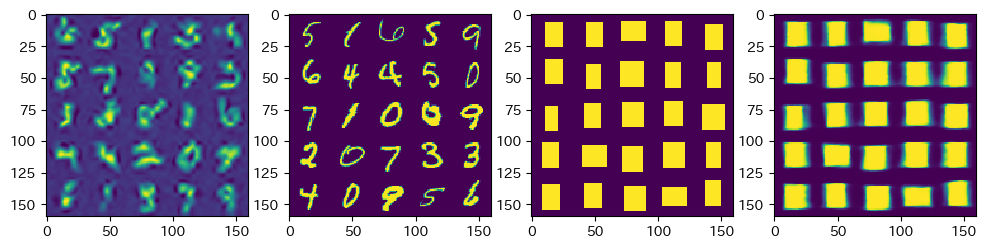

In [19]:
# 
for epoch_i in range(epoch_num):
    #
    train_num = int(np.round(len(X_train) * pick_per_epoch))
    train_idx = np.random.permutation(np.arange(train_num))
    iter_num  = (train_num // train_batch_size)
    
    ########################################################
    process_num   = iter_num # set number of process
    process_break = np.round(np.linspace(1, process_num, 50)) 
    process_i     = 0  
    print('epoch:%d' % (epoch_i + 1))
    print('--------------------------------------------------')
    print('START                                          END') 
    print('----+----1----+----2----+----3----+----4----+----5') 
    tic()
    ########################################################
    
    #
    for iter_i in range(iter_num):

        ####################################################
        # update processing progress
        process_i = process_i + 1   
        if (sum(process_break == process_i) > 0):
            for print_i in range(sum(process_break == process_i)): 
                print('*', end='', flush=True)                              
        ####################################################

        # 
        train_idx_tmp = train_idx[(iter_i * train_batch_size):((iter_i + 1) * train_batch_size)]
        # 
        X_train_tmp   = X_train[train_idx_tmp]
        y_train_tmp   = y_train[train_idx_tmp]
        # 
        X_train_tmp   = ppap_img_utl.imaugment_for_char(img=(X_train_tmp * 255), 
                                                        window_size_vert=np.shape(X_train_tmp)[1])
        X_train_tmp   = X_train_tmp / 255
        
        # 
        ppap_img_cls.train(model=model, 
                           device=device, 
                           optimizer=optimizer, 
                           loss_func=loss_func, 
                           X_image=X_train_tmp, 
                           y=y_train_tmp, 
                           classify_mode=False)
    
    # 
    y_train_hat = ppap_img_cls.feed_forward(model=model,  
                                            device=device, 
                                            X_image=X_train, 
                                            train_mode=False, 
                                            classify_mode=False)
    mae_train = np.mean(np.abs(y_train_hat - y_train))
    # 
    y_test_hat = ppap_img_cls.feed_forward(model=model,  
                                           device=device, 
                                           X_image=X_test, 
                                           train_mode=False, 
                                           classify_mode=False)
    mae_test = np.mean(np.abs(y_test_hat - y_test))
    
    ########################################################
    print('')
    str_now = datetime.now()  
    print('Accuracy on train = %.2f, test = %.2f  [' % (mae_train, mae_test), end='') 
    toc()
    print(']\n')
    
    # 
    if (((epoch_i + 1) % 1) == 0):
        # 
        fig = plt.figure(figsize=(12,8),dpi=100)
        plt.subplot(1, 4, 1)
        plt.imshow(X_train_tmp[0], clim=[0, 1])
        plt.subplot(1, 4, 2)
        plt.imshow(X_train[0], clim=[0, 1])
        plt.subplot(1, 4, 3)
        plt.imshow(y_train[0], clim=[0, 1])
        plt.subplot(1, 4, 4)
        plt.imshow(y_train_hat[0, 0, :, :], clim=[0, 1])
        plt.show()
    ########################################################
